In [1]:
!pip install git+https://github.com/oshadura/topcoffea.git@coffea-casa-analysis
! pip install awkward==1.3.0
#! pip install -e .

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/oshadura/topcoffea.git (to revision coffea-casa-analysis) to /tmp/pip-req-build-k7xxsyh6
  Created wheel for topcoffea: filename=topcoffea-0.0.0-py3-none-any.whl size=4514059 sha256=0ef291425ef9276b5bcb9980c1d0030fa94cedda3e13c6a83879d4a683055742
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jixxi63/wheels/3a/95/24/bfbb2d1dc4571114a0106e7d0d6a8124bcd2ad9e72ec9ea14e
Successfully built topcoffea
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     |████████████████████████████████| 8.0 MB 3.6 MB/s eta 0:00:01
  Attempting uninstall: awkward
    Found existing installation: awkward 1.2.0
    Uninstalling awkward-1.2.0:
      Successfully uninstalled awkward-1.2.0


In [2]:
import lz4.frame as lz4f
import pickle
import json
import time
import cloudpickle
import gzip
import os
from optparse import OptionParser

import uproot
import numpy as np
from coffea import hist, processor
from coffea.util import load, save
from coffea.nanoevents import NanoAODSchema

from topcoffea.modules import samples
from topcoffea.modules import fileReader

#FIXME: analysis is not installed anywhere (should be installed as well)
import topcoffea.analysis.topEFT.topeft

import importlib.resources

if hasattr(__builtins__,'__IPYTHON__'):
    import sys
    sys.argv = ['']

In [3]:
import argparse
parser = argparse.ArgumentParser(description='You can customize your run')
parser.add_argument('jsonFiles'           , nargs='?', help = 'Json file(s) containing files and metadata')
parser.add_argument('--prefix', '-r'     , nargs='?', help = 'Prefix or redirector to look for the files')
parser.add_argument('--test','-t'       , action='store_true'  , help = 'To perform a test, run over a few events in a couple of chunks')
parser.add_argument('--pretend'        , action='store_true'  , help = 'Read json files but, not execute the analysis')
#parser.add_argument('--nworkers','-n'   , default=8  , help = 'Number of workers')
parser.add_argument('--chunksize','-s'   , default=500000  , help = 'Number of events per chunk')
parser.add_argument('--nchunks','-c'   , default=None  , help = 'You can choose to run only a number of chunks')
parser.add_argument('--outname','-o'   , default='plotsTopEFT', help = 'Name of the output file with histograms')
parser.add_argument('--outpath','-p'   , default='histos', help = 'Name of the output directory')
parser.add_argument('--treename'   , default='Events', help = 'Name of the tree inside the files')
parser.add_argument('--do-errors', action='store_true', help = 'Save the w**2 coefficients')

args = parser.parse_args()

if args.jsonFiles is not None:
  jsonFiles    = args.jsonFiles
  print('jsonFiles {}'.format(args.jsonFiles))
else:
  with importlib.resources.path("topcoffea.json", "TTZToLLNuNu_M10.json") as path:
    jsonFiles = str(path)
    print('jsonFile was selected for UNL {}'.format(jsonFiles))
    
if args.prefix is not None:
  prefix    = args.prefix
else:
  prefix = "root://xcache//"

dotest     = args.test
#nworkers   = int(args.nworkers)
chunksize  = int(args.chunksize)
nchunks    = int(args.nchunks) if not args.nchunks is None else args.nchunks
outname    = args.outname
outpath    = args.outpath
pretend    = args.pretend
treename   = args.treename
do_errors = args.do_errors

if dotest:
  nchunks = 2
  chunksize = 10000
  nworkers = 1
  print('Running a fast test with %i workers, %i chunks of %i events'%(nworkers, nchunks, chunksize))

jsonFile was selected for UNL /opt/conda/lib/python3.8/site-packages/topcoffea/json/TTZToLLNuNu_M10.json


In [4]:
samplesdict = {}
allInputFiles = []

def LoadJsonToSampleName(jsonFile, prefix):
  sampleName = jsonFile if not '/' in jsonFile else jsonFile[jsonFile.rfind('/')+1:]
  if sampleName.endswith('.json'): sampleName = sampleName[:-5]
  with open(jsonFile) as jf:
    samplesdict[sampleName] = json.load(jf)
    samplesdict[sampleName]['redirector'] = prefix

if  isinstance(jsonFiles, str) and ',' in jsonFiles: jsonFiles = jsonFiles.replace(' ', '').split(',')
elif isinstance(jsonFiles, str)                     : jsonFiles = [jsonFiles]

for jsonFile in jsonFiles:
  if os.path.isdir(jsonFile):
    if not jsonFile.endswith('/'): jsonFile+='/'
    for f in os.path.listdir(jsonFile):
      if f.endswith('.json'): allInputFiles.append(jsonFile+f)
  else:
    allInputFiles.append(jsonFile)

print(allInputFiles)
# Read from cfg files
for f in allInputFiles:
  if not os.path.isfile(f):
    print('[WARNING] Input file "%s% not found!'%f)
    continue
  # This input file is a json file, not a cfg
  if f.endswith('.json'): 
    LoadJsonToSampleName(f, prefix)
  # Open cfg files
  else:
    with open(f) as fin:
      print(' >> Reading json from cfg file...')
      lines = fin.readlines()
      for l in lines:
        if '#' in l: l=l[:l.find('#')]
        l = l.replace(' ', '').replace('\n', '')
        if l == '': continue
        if ',' in l:
          l = l.split(',')
          for nl in l:
            if not os.path.isfile(l): prefix = nl
            else: LoadJsonToSampleName(nl, prefix)
        else:
          if not os.path.isfile(l): prefix = l
          else: LoadJsonToSampleName(l, prefix)

flist = {};
for sname in samplesdict.keys():
  redirector = samplesdict[sname]['redirector']
  flist[sname] = [(redirector+f) for f in samplesdict[sname]['files']]
  samplesdict[sname]['year'] = int(samplesdict[sname]['year'])
  samplesdict[sname]['xsec'] = float(samplesdict[sname]['xsec'])
  samplesdict[sname]['nEvents'] = int(samplesdict[sname]['nEvents'])
  samplesdict[sname]['nGenEvents'] = int(samplesdict[sname]['nGenEvents'])
  samplesdict[sname]['nSumOfWeights'] = float(samplesdict[sname]['nSumOfWeights'])

  # Print file info
  print('>> '+sname)
  print('   - isData?      : %s'   %('YES' if samplesdict[sname]['isData'] else 'NO'))
  print('   - year         : %i'   %samplesdict[sname]['year'])
  print('   - xsec         : %f'   %samplesdict[sname]['xsec'])
  print('   - histAxisName : %s'   %samplesdict[sname]['histAxisName'])
  print('   - options      : %s'   %samplesdict[sname]['options'])
  print('   - tree         : %s'   %samplesdict[sname]['treeName'])
  print('   - nEvents      : %i'   %samplesdict[sname]['nEvents'])
  print('   - nGenEvents   : %i'   %samplesdict[sname]['nGenEvents'])
  print('   - SumWeights   : %f'   %samplesdict[sname]['nSumOfWeights'])
  print('   - Prefix       : %s'   %samplesdict[sname]['redirector'])
  print('   - nFiles       : %i'   %len(samplesdict[sname]['files']))
  for fname in samplesdict[sname]['files']: print('     %s'%fname)

if pretend: 
  print('pretending...')
  exit() 

# Check that all datasets have the same list of WCs
for i,k in enumerate(samplesdict.keys()):
  if i == 0:
    wc_lst = samplesdict[k]['WCnames']
  if wc_lst != samplesdict[k]['WCnames']:
    raise Exception("Not all of the datasets have the same list of WCs.")

['/opt/conda/lib/python3.8/site-packages/topcoffea/json/TTZToLLNuNu_M10.json']
>> TTZToLLNuNu_M10
   - isData?      : NO
   - year         : 2018
   - xsec         : 0.252900
   - histAxisName : 
   - options      : 
   - tree         : Events
   - nEvents      : 14542666
   - nGenEvents   : 4876491
   - SumWeights   : 19992000.000000
   - Prefix       : root://xcache//
   - nFiles       : 18
     /store/user/jrgonzal/nanoAODcrab/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/mc2018_28apr2021_TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/210427_230816/0000/tree_1.root
     /store/user/jrgonzal/nanoAODcrab/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/mc2018_28apr2021_TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/210427_230816/0000/tree_10.root
     /store/user/jrgonzal/nanoAODcrab/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/mc2018_28apr2021_TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/210427_230816/0000/tree_11.root
     /store/user/jrgonzal/nanoAODcrab/TTZToLLNuNu_M-10_T

In [5]:
processor_instance = topcoffea.analysis.topEFT.topeft.AnalysisProcessor(samplesdict,wc_lst,do_errors)

from dask.distributed import Client, Worker, WorkerPlugin
import os
from typing import List
class DependencyInstaller(WorkerPlugin):
    def __init__(self, dependencies: List[str]):
        self._depencendies = " ".join(f"'{dep}'" for dep in dependencies)
    def setup(self, worker: Worker):
        os.system(f"pip install {self._depencendies}")
dependency_installer = DependencyInstaller([
    "git+https://github.com/oshadura/topcoffea.git@coffea-casa-analysis","awkward==1.3.0"
])

client = Client("tls://localhost:8786")
client.register_worker_plugin(dependency_installer)

executor_args = {
                 'schema': NanoAODSchema,
                 'client': client,
                 'savemetrics': True
}


# Run the processor and get the output                                                                                                                                                                     
tic = time.time()
output = processor.run_uproot_job(flist,
                                  treename=treename,
                                  processor_instance=processor_instance,
                                  executor=processor.dask_executor,
                                  executor_args=executor_args,
                                  chunksize=chunksize,
                                  maxchunks=nchunks
                                 )
toc = time.time()

print("Dask client:", client)
print("Total time: %.0f" % (toc - tic))
print("Events / s / thread: {:,.0f}".format(output[1]['entries'] / output[1]['processtime']))
print("Events / s: {:,.0f}".format(output[1]['entries'] / (toc - tic)))

os.system("mkdir -p histos/")
print('Saving output in %s...'%("histos/" + outname + ".pkl.gz"))
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(output, fout)
print('Done!')

Dask client: <Client: 'tls://192.168.182.162:8786' processes=2 threads=4, memory=12.72 GiB>
Total time: 444
Events / s / thread: 5,895
Events / s: 32,725
Saving output in histos/plotsTopEFT.pkl.gz...
Done!


Opening path:  histos/plotsTopEFT.pkl.gz
 >> looking for histograms...
Output histogram saved in temp.png


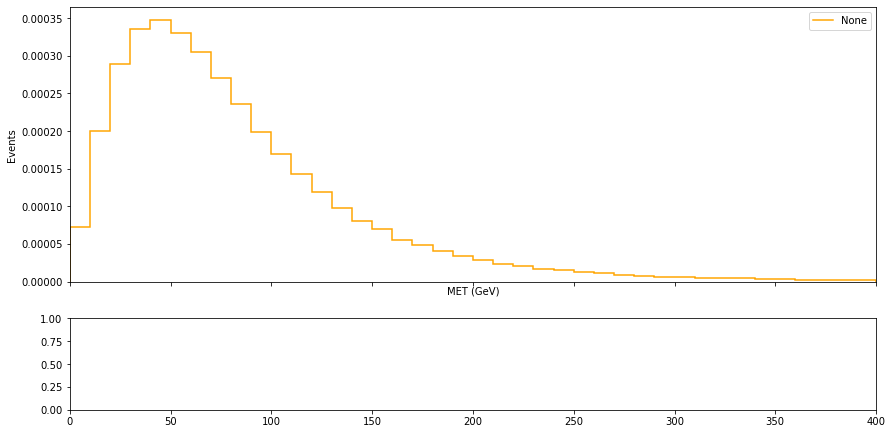

In [38]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
import numpy as np
from coffea import hist, processor
from coffea.hist import plot
from cycler import cycler

from topcoffea.plotter.OutText import OutText


path = 'histos/plotsTopEFT.pkl.gz'
outname = 'temp.png'

# Select variable, channel and cuts
var = 'met'
channel = ['eemSSonZ', 'eemSSoffZ', 'mmeSSonZ', 'mmeSSoffZ','eeeSSonZ', 'eeeSSoffZ', 'mmmSSonZ', 'mmmSSoffZ']
cut = 'base'
sumcharge = ['ch+', 'ch-']
systematic = 'nominal'

print('Opening path: ', path)
hists = {}
with gzip.open(path) as fin:
  hin = pickle.load(fin)
  print(' >> looking for histograms...')
  for k in hin[0].keys():
    if k in hists: hists[k]+=hin[0][k]
    else:          hists[k]=hin[0][k]


# Create figure
fig, (ax, rax) = plt.subplots(2, 1, figsize=(14,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# Select the histogram var, channel and cut
h = hists[var]
h = h.integrate('channel', channel)
h = h.integrate('cut', cut)
h = h.integrate('sumcharge', sumcharge)
h = h.integrate('systematic', systematic)

# Integrate over samples
h = h.sum('sample')

# Plot and save figure to outname
hist.plot1d(h, ax=ax, line_opts={'color':'orange'})
fig.savefig(outname)
print('Output histogram saved in %s'%outname)